In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x0.125': load_data('../stats/fpm_4_simplices_x0.5.json'),
    'Num cells x1': load_data('../stats/fpm_4_simplices_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    # 'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
from fpm_4_simplices import make_model

entry = data['Num cells x0.125']

model = make_model()
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num trans: 14


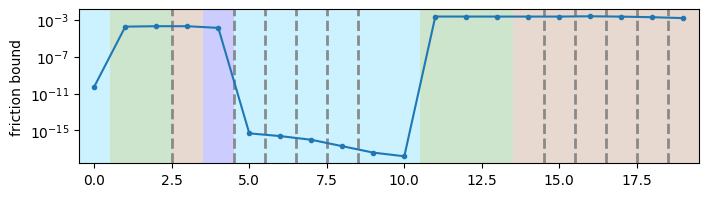

In [3]:
plt.figure(figsize=(8, 2))
color_sticking_sliding_open_transition(entry)
color_time_steps(entry, fill=False, legend=True)
plt.gca().grid(False)
plt.plot(get_friction_bound_norm(model, entry), marker='.')
plt.ylabel('friction bound')
plt.yscale('log')

In [4]:
mat_idx = 3
entry = data['Num cells x0.125']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

26


In [5]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)
model.ad_time_step.set_value(dt)

st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

9
5
0
0


In [6]:
fractures = model.mdg.subdomains(dim=model.nd - 1)
tmp = model.tangential_fracture_deformation_equation(fractures)
jac = tmp.value_and_jacobian(model.equation_system).jac
jac

lambda_dofs = model.equation_system.dofs_of([model.contact_traction_variable])
jac[:, lambda_dofs]

u_intf_dofs = model.equation_system.dofs_of([model.interface_displacement_variable])
jac[:, u_intf_dofs]

<28x84 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Row format>

Solve  took: 2.41
True residual decrease: 761767.437788689
PETSc Converged Reason: -5
lambda min: 1.471590162096126


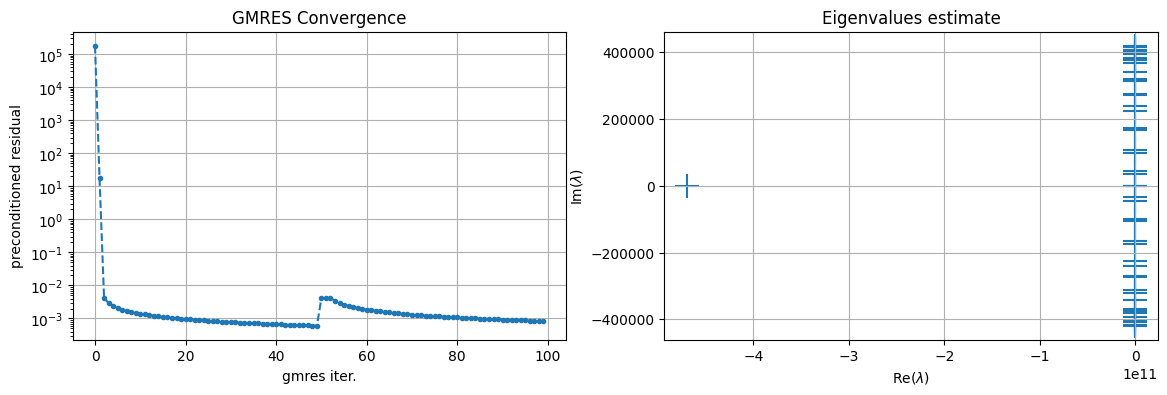

In [16]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs

solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

In [26]:
from mat_utils import inv


bmat = J
J44 = bmat[4,4].mat
J55 = bmat[5,5].mat
# J55_inv = inv_block_diag(J55, nd=model.nd)
J55_inv = inv(J55)
stab = bmat[4, 5].mat @ J55_inv @ bmat[5, 4].mat
st, sl, op, tr = model.sticking_sliding_open_transition()

# sliding_tang = np.repeat(sl, model.nd)
# sliding_tang[::model.nd] = 0  # we need only tangential
# stab[sliding_tang] = 0

sliding_norm = np.repeat(sl, model.nd)
# sliding_norm[1::model.nd] = 0
# sliding_norm[2::model.nd] = 0

# stab[sliding_norm, 0::3] = 0
# stab[sliding_norm, 1::3] = 0

S44 = J44 - stab

sticking = np.repeat(st, model.nd)
# S44[sticking] *= 0.5
# S44[sliding_norm] *= 0.5

j45_modified = bmat[4, 5].mat
# j45_modified[sticking] *= 0.5
# j45_modified[sliding_norm] *= 0.5

In [27]:
np.where(sl)

(array([0, 1, 6, 7, 9]),)

In [28]:
i = 6
J44[i*3:(i+1) * 3, i*3:(i+1) * 3].A

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.78037555e-05, -8.55679753e-07,  1.59599277e-05],
       [-8.55679753e-07, -1.83290980e-07,  4.93963636e-07]])

In [29]:
stab[i*3:(i+1) * 3, i*3:(i+1) * 3].A

array([[-5.49777745e+00, -2.13660314e+00, -6.13913072e+01],
       [-1.45736170e-05, -1.03434396e-04, -9.21867309e-07],
       [-8.14979559e-05,  3.32103066e-03,  4.98752637e-05]])

In [30]:
S44[i*3:(i+1) * 3, i*3:(i+1) * 3].A

array([[ 5.49777745e+00,  2.13660314e+00,  6.13913072e+01],
       [-1.32301385e-05,  1.02578717e-04,  1.68817950e-05],
       [ 8.06422762e-05, -3.32121395e-03, -4.93813001e-05]])

In [31]:
J45 = J[[4, 5]].copy().mat
J45_stab = J[[4, 5]].copy()
J45_stab[4, 4] = S44

cond(inv(J45_stab.mat) @ J45)

33.57574791547619

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


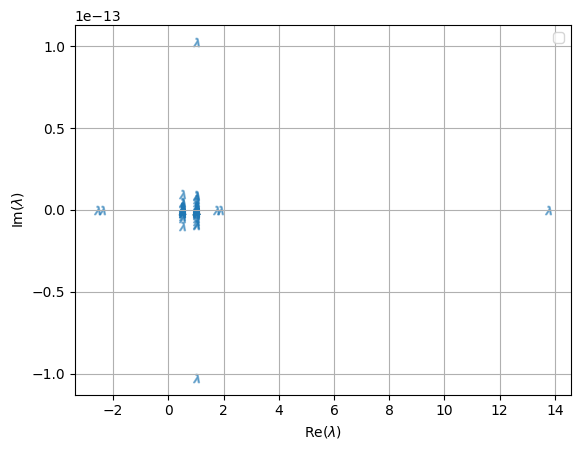

In [32]:
plot_eigs(inv(J45_stab.mat) @ J45)

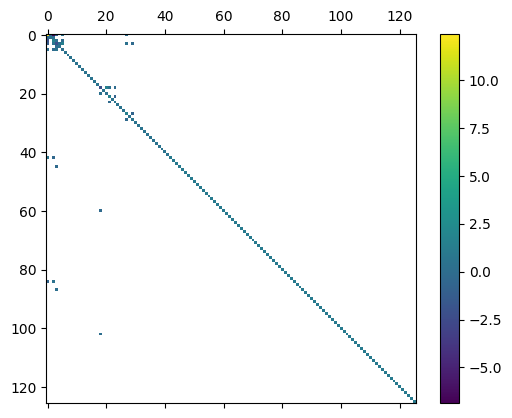

In [33]:
%matplotlib inline
plot_mat(inv(J45_stab.mat) @ J45, log=False, threshold=1e-1)

THERE ARE NEGATIVE ENTRIES IN THE MAIN DIAGONAL FOR THE BAD MATRIX #3

[3, 18] -> [1, 6]

In [34]:
np.where(sl)

(array([0, 1, 6, 7, 9]),)

In [35]:
approx_I = inv(J45_stab.mat) @ J45
approx_I.diagonal()

array([12.43303379,  0.5098237 ,  1.73558536, -2.14211497,  0.4960869 ,
        0.17083764,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       , -2.25907936,  0.49782128,
        0.35518701,  1.72566442,  0.50215384,  0.62409792,  0.5       ,
        0.5       ,  0.5       ,  1.57356927,  0.50041866,  0.64382572,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  